In [1]:
NOTE = 'CatBoost-Ordered特徴量ミニマム（カテゴリ変数指定）'
notebook_name = '059'

In [2]:
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [3]:
N = 5
CV = f'Stratified-Kfold(K={N})'

OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

# class_weights for CatBoostClassifier, copied from 020
CLASS_WEIGHTS = {
        0: 0.33822833,
        1: 0.4574968, 
        2: 0.71590909,
        3: 1.00280899,
        4: 3.17333333,
        5: 11.45454545,
        6: 194.72727273,
        7: 17.85
    }

059_submission.csv 059


In [4]:
def get_estimator(*,
                  categorical_features=None,
                  discrete_features=None,
                  vector_features=None,
                  features=None) -> Pipeline:

    clf = CatBoostClassifier(random_state=SEED,
                             cat_features=categorical_features,
                             train_dir=OUTPUT_DIR,
                             class_weights=CLASS_WEIGHTS,
                             boosting_type='Ordered',
                             n_estimators=300,
                             learning_rate=0.01)
    return Pipeline(
        steps=[
            ('estimator', clf)
         ]
    )

In [5]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [6]:
CATEGORICAL_FEATURES

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam',
 'b1',
 'b2',
 'b3']

In [7]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
discrete_features = list(set(minimal_features) - set(categorical_features))
print(categorical_features)
print(discrete_features)

# Execute if categories should be one-hot style
# for c in categorical_features:
#     assert(train[c].isin(test[c]).sum() == train.shape[0])
#     assert(test[c].isin(train[c]).sum() == test.shape[0])

# train = pd.get_dummies(train, columns=categorical_features, drop_first=True)
# test = pd.get_dummies(test, columns=categorical_features, drop_first=True)

# assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
# assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

# categorical_features_1hot = []
# for c in categorical_features:
#     categorical_features_1hot += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
# print(categorical_features_1hot)

# features = discrete_features + categorical_features_1hot
features = discrete_features + categorical_features

['b1', 'b2', 'b3', 'batterID', 'pitcherID', 'Match', 'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher', 'isBottom', 'batterTeam', 'pitcherTeam']
['numRunners', 'totalPitchingCount', 'B', 'O', 'S', 'inningNo']


In [8]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [9]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [10]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )

    clf = get_estimator(features=features,
                        discrete_features=discrete_features,
                        categorical_features=categorical_features)
#     class_weight = compute_class_weight('balanced',
#                                         classes=np.sort(train.y.unique()),
#                                         y=y_train.values)
#     class_weight = dict(
#         zip(
#             np.sort(train.y.unique()),
#             class_weight
#         )
#     )
#     sample_weight = y_train.map(class_weight)
#     assert(sample_weight.isnull().sum() == 0)
    sample_weight = None
    clf.fit(X_train,
            y_train.values,
            estimator__sample_weight=sample_weight)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



0:	learn: 2.0794323	total: 237ms	remaining: 1m 10s
1:	learn: 2.0781916	total: 613ms	remaining: 1m 31s
2:	learn: 2.0781827	total: 679ms	remaining: 1m 7s
3:	learn: 2.0779722	total: 806ms	remaining: 59.6s
4:	learn: 2.0773942	total: 1.26s	remaining: 1m 14s
5:	learn: 2.0767156	total: 1.6s	remaining: 1m 18s
6:	learn: 2.0767073	total: 1.71s	remaining: 1m 11s
7:	learn: 2.0766064	total: 1.9s	remaining: 1m 9s
8:	learn: 2.0759200	total: 2.16s	remaining: 1m 9s
9:	learn: 2.0754964	total: 2.63s	remaining: 1m 16s
10:	learn: 2.0731249	total: 3.39s	remaining: 1m 29s
11:	learn: 2.0724398	total: 3.81s	remaining: 1m 31s
12:	learn: 2.0714092	total: 4.13s	remaining: 1m 31s
13:	learn: 2.0707680	total: 4.93s	remaining: 1m 40s
14:	learn: 2.0699653	total: 5.19s	remaining: 1m 38s
15:	learn: 2.0689867	total: 5.88s	remaining: 1m 44s
16:	learn: 2.0689784	total: 6.04s	remaining: 1m 40s
17:	learn: 2.0686620	total: 6.38s	remaining: 1m 39s
18:	learn: 2.0678443	total: 6.96s	remaining: 1m 42s
19:	learn: 2.0674702	total: 

160:	learn: 1.9716070	total: 57.9s	remaining: 50s
161:	learn: 1.9709421	total: 58.2s	remaining: 49.6s
162:	learn: 1.9689087	total: 58.7s	remaining: 49.3s
163:	learn: 1.9682923	total: 58.8s	remaining: 48.8s
164:	learn: 1.9663478	total: 59.4s	remaining: 48.6s
165:	learn: 1.9660327	total: 59.9s	remaining: 48.3s
166:	learn: 1.9656637	total: 1m	remaining: 48.1s
167:	learn: 1.9647875	total: 1m	remaining: 47.9s
168:	learn: 1.9644683	total: 1m 1s	remaining: 47.7s
169:	learn: 1.9640768	total: 1m 1s	remaining: 47.2s
170:	learn: 1.9632565	total: 1m 2s	remaining: 46.9s
171:	learn: 1.9630248	total: 1m 2s	remaining: 46.3s
172:	learn: 1.9629611	total: 1m 2s	remaining: 45.8s
173:	learn: 1.9622521	total: 1m 2s	remaining: 45.5s
174:	learn: 1.9616337	total: 1m 3s	remaining: 45.3s
175:	learn: 1.9616115	total: 1m 3s	remaining: 44.8s
176:	learn: 1.9612875	total: 1m 3s	remaining: 44.3s
177:	learn: 1.9612439	total: 1m 3s	remaining: 43.8s
178:	learn: 1.9608095	total: 1m 4s	remaining: 43.4s
179:	learn: 1.960512

2:	learn: 2.0764843	total: 1.84s	remaining: 3m 1s
3:	learn: 2.0747807	total: 2.25s	remaining: 2m 46s
4:	learn: 2.0722256	total: 2.93s	remaining: 2m 52s
5:	learn: 2.0717590	total: 3.38s	remaining: 2m 45s
6:	learn: 2.0710280	total: 3.61s	remaining: 2m 31s
7:	learn: 2.0706582	total: 4.37s	remaining: 2m 39s
8:	learn: 2.0704655	total: 4.69s	remaining: 2m 31s
9:	learn: 2.0697330	total: 5.26s	remaining: 2m 32s
10:	learn: 2.0697326	total: 5.35s	remaining: 2m 20s
11:	learn: 2.0696791	total: 5.47s	remaining: 2m 11s
12:	learn: 2.0686960	total: 6.16s	remaining: 2m 15s
13:	learn: 2.0673421	total: 6.87s	remaining: 2m 20s
14:	learn: 2.0666266	total: 7.07s	remaining: 2m 14s
15:	learn: 2.0662667	total: 7.34s	remaining: 2m 10s
16:	learn: 2.0649152	total: 7.86s	remaining: 2m 10s
17:	learn: 2.0648291	total: 8.05s	remaining: 2m 6s
18:	learn: 2.0644086	total: 8.31s	remaining: 2m 2s
19:	learn: 2.0614374	total: 9.01s	remaining: 2m 6s
20:	learn: 2.0612696	total: 9.32s	remaining: 2m 3s
21:	learn: 2.0608019	tota

161:	learn: 1.9592413	total: 1m 8s	remaining: 58s
162:	learn: 1.9580930	total: 1m 8s	remaining: 57.9s
163:	learn: 1.9575784	total: 1m 9s	remaining: 57.6s
164:	learn: 1.9569334	total: 1m 9s	remaining: 57.3s
165:	learn: 1.9563209	total: 1m 10s	remaining: 56.7s
166:	learn: 1.9557201	total: 1m 10s	remaining: 56.1s
167:	learn: 1.9542931	total: 1m 11s	remaining: 55.8s
168:	learn: 1.9542726	total: 1m 11s	remaining: 55.2s
169:	learn: 1.9542498	total: 1m 11s	remaining: 54.5s
170:	learn: 1.9540222	total: 1m 11s	remaining: 54s
171:	learn: 1.9533531	total: 1m 12s	remaining: 53.7s
172:	learn: 1.9530728	total: 1m 12s	remaining: 53.1s
173:	learn: 1.9530399	total: 1m 12s	remaining: 52.5s
174:	learn: 1.9528201	total: 1m 12s	remaining: 52s
175:	learn: 1.9521653	total: 1m 13s	remaining: 51.8s
176:	learn: 1.9519138	total: 1m 13s	remaining: 51.3s
177:	learn: 1.9516668	total: 1m 14s	remaining: 50.8s
178:	learn: 1.9510389	total: 1m 14s	remaining: 50.4s
179:	learn: 1.9508112	total: 1m 14s	remaining: 49.9s
180

3:	learn: 2.0755729	total: 1.52s	remaining: 1m 52s
4:	learn: 2.0740648	total: 2s	remaining: 1m 57s
5:	learn: 2.0740643	total: 2.07s	remaining: 1m 41s
6:	learn: 2.0740638	total: 2.13s	remaining: 1m 29s
7:	learn: 2.0730746	total: 2.34s	remaining: 1m 25s
8:	learn: 2.0725154	total: 2.95s	remaining: 1m 35s
9:	learn: 2.0719993	total: 3.07s	remaining: 1m 28s
10:	learn: 2.0718847	total: 3.19s	remaining: 1m 23s
11:	learn: 2.0711548	total: 3.58s	remaining: 1m 26s
12:	learn: 2.0701335	total: 4.27s	remaining: 1m 34s
13:	learn: 2.0700690	total: 4.54s	remaining: 1m 32s
14:	learn: 2.0694642	total: 4.7s	remaining: 1m 29s
15:	learn: 2.0694638	total: 4.75s	remaining: 1m 24s
16:	learn: 2.0685646	total: 5.02s	remaining: 1m 23s
17:	learn: 2.0685642	total: 5.09s	remaining: 1m 19s
18:	learn: 2.0682033	total: 5.37s	remaining: 1m 19s
19:	learn: 2.0678866	total: 5.92s	remaining: 1m 22s
20:	learn: 2.0663117	total: 6.68s	remaining: 1m 28s
21:	learn: 2.0660750	total: 6.8s	remaining: 1m 25s
22:	learn: 2.0655352	tot

162:	learn: 1.9663658	total: 1m 8s	remaining: 58s
163:	learn: 1.9651860	total: 1m 9s	remaining: 57.7s
164:	learn: 1.9648991	total: 1m 9s	remaining: 57s
165:	learn: 1.9648067	total: 1m 9s	remaining: 56.3s
166:	learn: 1.9640826	total: 1m 10s	remaining: 56s
167:	learn: 1.9635898	total: 1m 10s	remaining: 55.5s
168:	learn: 1.9629470	total: 1m 11s	remaining: 55.2s
169:	learn: 1.9628190	total: 1m 11s	remaining: 54.6s
170:	learn: 1.9621883	total: 1m 12s	remaining: 54.3s
171:	learn: 1.9618731	total: 1m 12s	remaining: 53.8s
172:	learn: 1.9613574	total: 1m 12s	remaining: 53.6s
173:	learn: 1.9609870	total: 1m 13s	remaining: 53.1s
174:	learn: 1.9608189	total: 1m 13s	remaining: 52.5s
175:	learn: 1.9596119	total: 1m 14s	remaining: 52.2s
176:	learn: 1.9592182	total: 1m 14s	remaining: 51.8s
177:	learn: 1.9590533	total: 1m 15s	remaining: 51.5s
178:	learn: 1.9584844	total: 1m 15s	remaining: 51s
179:	learn: 1.9582184	total: 1m 15s	remaining: 50.4s
180:	learn: 1.9578510	total: 1m 15s	remaining: 49.8s
181:	

4:	learn: 2.0735152	total: 2.35s	remaining: 2m 18s
5:	learn: 2.0730622	total: 2.62s	remaining: 2m 8s
6:	learn: 2.0729506	total: 2.81s	remaining: 1m 57s
7:	learn: 2.0728772	total: 3.23s	remaining: 1m 57s
8:	learn: 2.0724726	total: 3.83s	remaining: 2m 3s
9:	learn: 2.0701439	total: 4.27s	remaining: 2m 3s
10:	learn: 2.0679647	total: 5.03s	remaining: 2m 12s
11:	learn: 2.0666062	total: 5.6s	remaining: 2m 14s
12:	learn: 2.0649739	total: 6.3s	remaining: 2m 19s
13:	learn: 2.0648102	total: 6.58s	remaining: 2m 14s
14:	learn: 2.0644207	total: 7.22s	remaining: 2m 17s
15:	learn: 2.0639652	total: 7.75s	remaining: 2m 17s
16:	learn: 2.0634704	total: 8.09s	remaining: 2m 14s
17:	learn: 2.0631180	total: 8.49s	remaining: 2m 13s
18:	learn: 2.0620211	total: 8.8s	remaining: 2m 10s
19:	learn: 2.0608621	total: 9.41s	remaining: 2m 11s
20:	learn: 2.0606544	total: 10.1s	remaining: 2m 13s
21:	learn: 2.0595186	total: 10.8s	remaining: 2m 16s
22:	learn: 2.0583610	total: 11.6s	remaining: 2m 19s
23:	learn: 2.0582379	tot

163:	learn: 1.9629295	total: 1m 8s	remaining: 57.2s
164:	learn: 1.9628114	total: 1m 9s	remaining: 56.6s
165:	learn: 1.9627908	total: 1m 9s	remaining: 55.9s
166:	learn: 1.9623531	total: 1m 9s	remaining: 55.3s
167:	learn: 1.9623402	total: 1m 9s	remaining: 54.7s
168:	learn: 1.9613843	total: 1m 10s	remaining: 54.3s
169:	learn: 1.9609893	total: 1m 10s	remaining: 53.7s
170:	learn: 1.9602852	total: 1m 10s	remaining: 53.1s
171:	learn: 1.9597836	total: 1m 10s	remaining: 52.7s
172:	learn: 1.9591044	total: 1m 11s	remaining: 52.3s
173:	learn: 1.9588019	total: 1m 11s	remaining: 51.7s
174:	learn: 1.9576770	total: 1m 11s	remaining: 51.4s
175:	learn: 1.9575575	total: 1m 12s	remaining: 50.7s
176:	learn: 1.9575411	total: 1m 12s	remaining: 50.1s
177:	learn: 1.9572722	total: 1m 12s	remaining: 49.7s
178:	learn: 1.9552627	total: 1m 13s	remaining: 49.5s
179:	learn: 1.9540590	total: 1m 13s	remaining: 49.1s
180:	learn: 1.9534511	total: 1m 14s	remaining: 48.9s
181:	learn: 1.9533093	total: 1m 14s	remaining: 48.6

5:	learn: 2.0757463	total: 1.71s	remaining: 1m 23s
6:	learn: 2.0756370	total: 1.79s	remaining: 1m 15s
7:	learn: 2.0742557	total: 2.21s	remaining: 1m 20s
8:	learn: 2.0742552	total: 2.25s	remaining: 1m 12s
9:	learn: 2.0741132	total: 2.38s	remaining: 1m 9s
10:	learn: 2.0736920	total: 2.47s	remaining: 1m 4s
11:	learn: 2.0735072	total: 2.9s	remaining: 1m 9s
12:	learn: 2.0734286	total: 3.1s	remaining: 1m 8s
13:	learn: 2.0731246	total: 3.53s	remaining: 1m 12s
14:	learn: 2.0719390	total: 3.96s	remaining: 1m 15s
15:	learn: 2.0702788	total: 4.53s	remaining: 1m 20s
16:	learn: 2.0699762	total: 4.93s	remaining: 1m 22s
17:	learn: 2.0680897	total: 5.44s	remaining: 1m 25s
18:	learn: 2.0673375	total: 5.93s	remaining: 1m 27s
19:	learn: 2.0672006	total: 6.02s	remaining: 1m 24s
20:	learn: 2.0665450	total: 6.41s	remaining: 1m 25s
21:	learn: 2.0665447	total: 6.45s	remaining: 1m 21s
22:	learn: 2.0661405	total: 6.53s	remaining: 1m 18s
23:	learn: 2.0655334	total: 6.68s	remaining: 1m 16s
24:	learn: 2.0653230	to

166:	learn: 1.9767571	total: 44.4s	remaining: 35.4s
167:	learn: 1.9767422	total: 44.5s	remaining: 34.9s
168:	learn: 1.9767226	total: 44.6s	remaining: 34.5s
169:	learn: 1.9765142	total: 44.6s	remaining: 34.1s
170:	learn: 1.9755446	total: 44.9s	remaining: 33.9s
171:	learn: 1.9753181	total: 45s	remaining: 33.5s
172:	learn: 1.9752830	total: 45.1s	remaining: 33.1s
173:	learn: 1.9743323	total: 45.4s	remaining: 32.9s
174:	learn: 1.9743323	total: 45.4s	remaining: 32.5s
175:	learn: 1.9738578	total: 45.9s	remaining: 32.4s
176:	learn: 1.9738195	total: 46s	remaining: 32s
177:	learn: 1.9709874	total: 46.5s	remaining: 31.9s
178:	learn: 1.9707928	total: 46.7s	remaining: 31.6s
179:	learn: 1.9701352	total: 47.1s	remaining: 31.4s
180:	learn: 1.9692893	total: 47.6s	remaining: 31.3s
181:	learn: 1.9692892	total: 47.6s	remaining: 30.9s
182:	learn: 1.9692890	total: 47.7s	remaining: 30.5s
183:	learn: 1.9691354	total: 47.8s	remaining: 30.1s
184:	learn: 1.9690273	total: 48s	remaining: 29.8s
185:	learn: 1.968624

In [11]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.114419,0.115378
std,0.015700,0.012076
min,0.086530,0.099281
25%,0.119460,0.105857
50%,0.120033,0.120778
75%,0.121896,0.125419
max,0.124179,0.125555


In [12]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,1,0,1
1,1,1,7,0,1
2,2,0,5,0,1
3,3,2,5,0,1
4,4,4,5,0,1
...,...,...,...,...,...
17126,9690,0,1,0,5
17129,9693,1,2,0,5
17130,16833,1,1,0,5
17133,9762,1,1,0,5


In [13]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.112875,0.111462,0.131424,0.127276,0.128611,0.145974,0.120525,0.121853,27446,1
1,0.125361,0.116223,0.137702,0.121253,0.116869,0.117185,0.156233,0.109174,113,1
2,0.149805,0.152047,0.125976,0.109853,0.101067,0.102161,0.149670,0.109422,4479,1
3,0.151265,0.155679,0.130737,0.116799,0.104255,0.112214,0.108290,0.120760,29080,1
4,0.137319,0.130685,0.136680,0.123953,0.116997,0.125332,0.100840,0.128194,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.126403,0.147170,0.117020,0.135043,0.124137,0.117592,0.110661,0.121974,24272,5
33804,0.115640,0.119293,0.136386,0.151847,0.140392,0.128394,0.100652,0.107396,29106,5
33805,0.115051,0.119924,0.144252,0.155875,0.142404,0.145597,0.060515,0.116382,20679,5
33806,0.129160,0.127456,0.137261,0.145400,0.143040,0.119075,0.088928,0.109679,25901,5


In [14]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,0.650284,0.738937,0.636658,0.688303,0.637313,0.640588,0.347374,0.660543
1,1,0.718497,0.791737,0.578563,0.614790,0.573718,0.615725,0.434299,0.672669
2,2,0.558300,0.534021,0.661857,0.695532,0.697935,0.631977,0.626542,0.593835
3,3,0.719799,0.813989,0.577837,0.608762,0.592748,0.560459,0.529819,0.596587
4,4,0.763978,0.775915,0.636014,0.569914,0.562770,0.523331,0.541664,0.626414
...,...,...,...,...,...,...,...,...,...
33803,33803,0.648894,0.640800,0.632036,0.676796,0.653967,0.626152,0.490986,0.630368
33804,33804,0.711941,0.789039,0.588493,0.621422,0.591961,0.627377,0.401430,0.668336
33805,33805,0.716189,0.776855,0.587614,0.615590,0.591181,0.615374,0.390115,0.707083
33806,33806,0.574219,0.615236,0.656047,0.724930,0.713975,0.656315,0.505551,0.553728


In [15]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,1
2,2,4
3,3,1
4,4,1
...,...,...
33803,33803,3
33804,33804,1
33805,33805,1
33806,33806,3


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.020498
1    0.450485
2    0.042948
3    0.277863
4    0.059927
5    0.016091
6    0.086518
7    0.045670
Name: y, dtype: float64

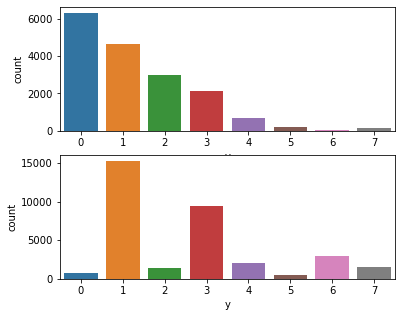

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [17]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [18]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.1144194996032376, 0.11537796792263129)

In [19]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"059_submission.csv","Stratified-Kfold(K=5)","0.114419","0.115378","","CatBoost-Ordered特徴量ミニマム（カテゴリ変数指定）"


In [20]:
%%time
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()

Wall time: 27.3 ms


In [21]:
%%time
imp_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 10 ms


In [22]:
imp_df

,feature,importance,fold
0,numRunners,0.405175,1
1,totalPitchingCount,3.109892,1
2,B,5.513781,1
3,O,8.300303,1
4,S,7.237339,1
...,...,...,...
13,isPitcherHandLeft,0.217116,5
14,isBatterPitcher,0.000000,5
15,isBottom,0.000000,5
16,batterTeam,6.272891,5


In [23]:
%%time
coef_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=features)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 0 ns


In [24]:
coef_df

""
